In [30]:
###############
### Imports ###
###############

import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline
sns.set()

In [31]:
#################
### Load Data ###
#################

covid_data = pd.read_csv('..\Sklearn_LR\data\Covid_data.csv')
CC = covid_data.copy()
CC.rename(columns=
                {CC.columns[0]: 'Date', 
                 CC.columns[1]: 'Link',
                 CC.columns[2]: 'Laboratory',
                 CC.columns[3]: 'Moving_Avg'}, inplace=True)
CC.dropna(inplace=True)

In [32]:
#######################
### Create Datetime ###
#######################

CC['Date'] = pd.to_datetime(CC['Date'], format='%Y/%m/%d').dt.date
first_lockdown = datetime.date(2020,3,20)
schools_reopen = datetime.date(2020,8,31)
second_lockdown = datetime.date(2020,12,25)

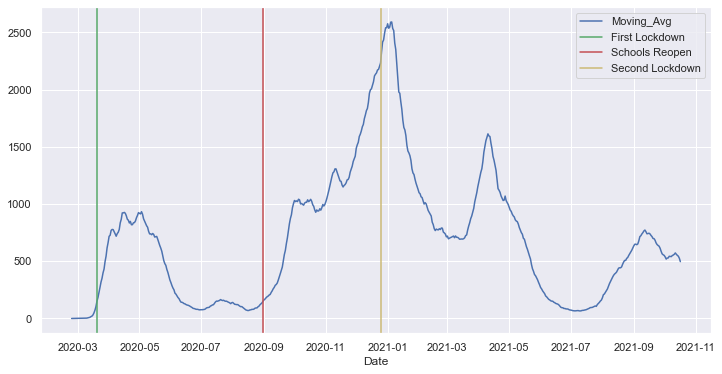

In [33]:
######################
### Visualize Data ###
######################

fig, ax = plt.subplots(figsize=(12,6))
CC.plot(x='Date', y='Moving_Avg', ax=ax)
ax.axvline(first_lockdown, color = 'g', label = 'First Lockdown')
ax.axvline(schools_reopen, color = 'r', label = 'Schools Reopen')
ax.axvline(second_lockdown, color = 'y', label = 'Second Lockdown')
ax.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

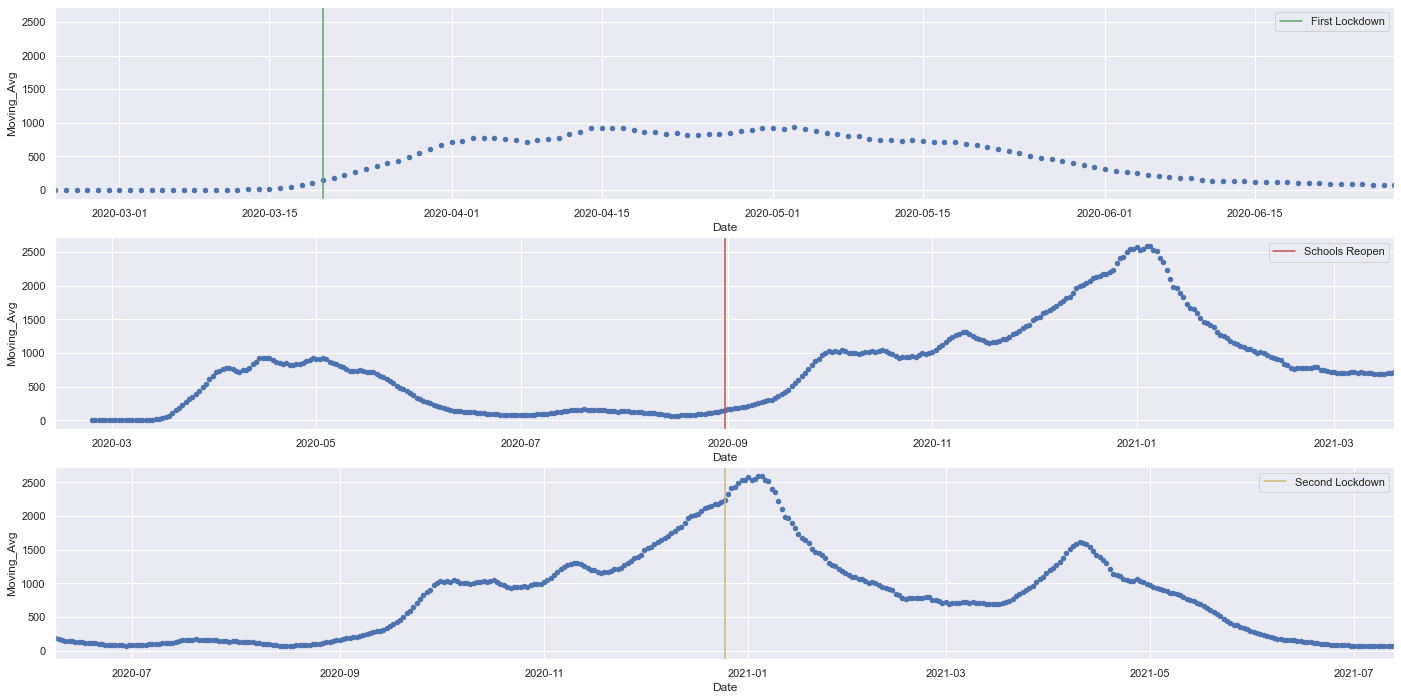

In [34]:
delta1 = datetime.timedelta(100)
delta2 = datetime.timedelta(200)

fig, axes = plt.subplots(3,1,figsize=(24,12))
CC.plot.scatter(x='Date', y='Moving_Avg', ax = axes[0], color = 'b')
axes[0].set_xlim([CC.iloc[0][0],first_lockdown+delta1])
axes[0].axvline(first_lockdown, color = 'g', label = 'First Lockdown')
CC.plot.scatter(x='Date', y='Moving_Avg', ax = axes[1], color = 'b')
axes[1].set_xlim([schools_reopen-delta2,schools_reopen+delta2])
axes[1].axvline(schools_reopen, color = 'r', label = 'Schools Reopen')
CC.plot.scatter(x='Date', y='Moving_Avg', ax = axes[2], color = 'b')
axes[2].set_xlim([second_lockdown-delta2,second_lockdown+delta2])
axes[2].axvline(second_lockdown, color = 'y', label = 'Second Lockdown')
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show


In [35]:
#########################
### Center Thresholds ###
#########################

def generate(df,date,start, end):
    df = CC.copy()
    df['Threshold'] = df['Date'] > date
    df['Ordinal'] = df['Date'].apply(lambda x : x.toordinal())
    ordinaldate = date.toordinal()
    df['Significant'] = ordinaldate*df['Threshold']
    df = df[['Ordinal','Significant', 'Moving_Avg']]
    df = df.loc[(df['Ordinal'] > ordinaldate - start) & (df['Ordinal'] < ordinaldate + end)]
    return df

FLD = pd.DataFrame(columns=['Ordinal', 'Significant', 'Moving_Avg'], index=range(1))
FLD = generate(FLD,first_lockdown,25,25)

SRD = pd.DataFrame(columns=['Ordinal', 'Significant', 'Moving_Avg'], index=range(1))
SRD = generate(SRD,schools_reopen,60,60)

SLD = pd.DataFrame(columns=['Ordinal', 'Significant', 'Moving_Avg'], index=range(1))
SLD = generate(SLD,second_lockdown,60,60)

In [36]:
#############################
### Checking Significance ###
#############################

def significance(df):
    X = df[['Ordinal','Significant']]
    y = df['Moving_Avg']

    model = sm.OLS(y, sm.add_constant(X)).fit()
    return model.summary().tables[1]

print(significance(FLD))
print(significance(SRD))
print(significance(SLD))

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.102e+07   1.58e+06     -6.993      0.000   -1.42e+07   -7.85e+06
Ordinal        14.9463      2.137      6.993      0.000      10.644      19.249
Significant     0.0003    8.2e-05      3.596      0.001       0.000       0.000
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.067e+06   7.48e+05     -8.107      0.000   -7.55e+06   -4.58e+06
Ordinal         8.2253      1.015      8.107      0.000       6.216      10.235
Significant     0.0002   9.45e-05      1.647      0.102   -3.15e-05       0.000
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         5.26e+06   2.07e+06      2

From this we can see that reopening the schools had no effect on the 7-day avg while both lockdowns were significant.